# Background

In 2016 the NEON AOP flew the PRIN site in D11 on a poor weather day to ensure coverage of the site. The following day, the weather improved and the site was flown again to collect good weather spectrometer data. Having collections only one day apart provides an opportunity to assess LiDAR uncertainty because we should expect that nothing has chnaged between the two collects. In this exercise we will analyze the several L3 LIDAR rasters to assess the uncertainty.

## Objective

In this lesson we will

1) Load several tif files with metadata
2) Difference tif files
3) Create histograms
4) Remove areas of DSM / DTMs through logical indexing of the CHM


In [23]:
import sys
sys.version

'3.4.5 |Anaconda custom (64-bit)| (default, Jul  5 2016, 14:53:07) [MSC v.1600 64 bit (AMD64)]'

In [24]:
import gdal
import h5py
import numpy as np
from math import floor
import os
import matplotlib.pyplot as plt
%matplotlib inline

Define plotting function from Day1  / Day 2. This time we've added an input for the colormap limits.

In [25]:
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(diff_dsm_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [26]:
print('Start Uncertainty Script')

Start Uncertainty Script


Define all of the input files. This will include two Digital Surface Model (DSMs) tifs from the flight days, two Digital Terrain Models (DTMs) from the flight days, and a single Canopy Height Model (CHM). In this case, all inoput GeoTiff rasts are a single tile of the site that measures 1000 m by 1000 m.

In [27]:
dsm1_filename = 'C:/RSDI_2017/data/PRIN/2016_PRIN_1_607000_3696000_DSM.tif'
dsm2_filename = 'C:/RSDI_2017/data/PRIN/2016_PRIN_2_607000_3696000_DSM.tif'
dtm1_filename = 'C:/RSDI_2017/data/PRIN/2016_PRIN_1_607000_3696000_DTM.tif'
dtm2_filename = 'C:/RSDI_2017/data/PRIN/2016_PRIN_2_607000_3696000_DTM.tif'
chm_filename = 'C:/RSDI_2017/data/PRIN/2016_PRIN_1_607000_3696000_pit_free_CHM.tif'

Open all of the files for accessing the data and meta data.

In [28]:
dsm1_dataset = gdal.Open(dsm1_filename)
dsm2_dataset = gdal.Open(dsm2_filename)
dtm1_dataset = gdal.Open(dtm1_filename)
dtm2_dataset = gdal.Open(dtm2_filename)
chm_dataset = gdal.Open(chm_filename)

Next we will read the dimensions from the tif meta data for the first DSM. This includes the data columns, rows band numbers and mapping info.

In [29]:
cols_dsm1 = dsm1_dataset.RasterXSize
rows_dsm1 = dsm1_dataset.RasterYSize
bands_dsm1 = dsm1_dataset.RasterCount
mapinfo_dsm1 = dsm1_dataset.GetGeoTransform()

Using the mapping information, we will determine the partial extents of the data by adding the number of columns and rows to the UTM northing and easting of the upper left corner. Since we know all the data is from the same tile, this data will be valid for all tiles. 

In [30]:
xMin = mapinfo_dsm1[0]
yMax = mapinfo_dsm1[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_dsm1[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_dsm1[5]
image_extent = (xMin,xMax,yMin,yMax)

We will now read in the meta data for the remaining tiles

In [31]:
cols_dsm2 = dsm2_dataset.RasterXSize
rows_dsm2 = dsm2_dataset.RasterYSize
bands_dsm2 = dsm2_dataset.RasterCount

cols_dtm1 = dtm1_dataset.RasterXSize
rows_dtm1 = dtm1_dataset.RasterYSize
bands_dtm1 = dtm1_dataset.RasterCount

cols_dtm2 = dtm2_dataset.RasterXSize
rows_dtm2 = dtm2_dataset.RasterYSize
bands_dtm2 = dtm2_dataset.RasterCount

cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount

Let's check all the datasets to make sure dimensions are equivalent as the following code will fail rasters of varied sizes are used. In this case, we will exit the script with a warning message.

In [32]:
if (cols_dsm1 != cols_dsm2 or cols_dsm1 != cols_dtm1 or cols_dsm1 != cols_dtm2 or cols_dsm1 != cols_chm):
    sys.exit('Columns from datasets do not match')
       
if (rows_dsm1 != rows_dsm2 or rows_dsm1 != rows_dtm1 or rows_dsm1 != rows_dtm2 or rows_dsm1 != rows_chm):
    sys.exit('Rows from datasets do not match')
       
if (bands_dsm1 != 1 or bands_dsm2 != 1 or bands_dtm1 != 1 or bands_dtm2 != 1 or bands_chm != 1):
    sys.exit('There are the wrong number of bands in a dataset')


Next we'll assign the raster object for each dataset

In [33]:
dsm1_raster = dsm1_dataset.GetRasterBand(1)
dsm2_raster = dsm2_dataset.GetRasterBand(1)
dtm1_raster = dtm1_dataset.GetRasterBand(1)
dtm2_raster = dtm2_dataset.GetRasterBand(1)
chm_raster = chm_dataset.GetRasterBand(1)

...and the associated NoData values

In [34]:
noDataVal_dsm1 = dsm1_raster.GetNoDataValue()
noDataVal_dsm2 = dsm2_raster.GetNoDataValue()
noDataVal_dtm1 = dtm1_raster.GetNoDataValue()
noDataVal_dtm2 = dtm2_raster.GetNoDataValue()
noDataVal_chm = chm_raster.GetNoDataValue()

Now we will read in the raster data as two-dimensional arrays with the float data type, and assign all NoData values as NaNs. We must convert these to NaNs as the NoData value will bias the statistics.

In [35]:
dsm_array1 = dsm1_raster.ReadAsArray(0,0,cols_dsm1,rows_dsm1).astype(np.float)
dsm_array2 = dsm2_raster.ReadAsArray(0,0,cols_dsm2,rows_dsm2).astype(np.float)
dtm_array1 = dtm1_raster.ReadAsArray(0,0,cols_dsm1,rows_dsm1).astype(np.float)
dtm_array2 = dtm2_raster.ReadAsArray(0,0,cols_dsm2,rows_dsm2).astype(np.float)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

dsm_array1[dsm_array1==int(noDataVal_dsm1)]=np.nan 
dsm_array2[dsm_array2==int(noDataVal_dsm2)]=np.nan
dtm_array1[dtm_array1==int(noDataVal_dtm1)]=np.nan 
dtm_array2[dtm_array2==int(noDataVal_dtm2)]=np.nan           
chm_array[chm_array==int(noDataVal_chm)]=np.nan 

To get an estaimte of the DSM and DTM uncertainty, we now subtract the tiles that were acquired on the two different days

In [36]:
diff_dsm_array = np.subtract(dsm_array1,dsm_array2)
diff_dtm_array = np.subtract(dtm_array1,dtm_array2) 

Let's get some summary statistics for the DSM difference...

In [37]:
diff_dsm_array_mean = np.mean(diff_dsm_array)
diff_dsm_array_std = np.std(diff_dsm_array)
print('Mean difference in DSMs: ',round(diff_dsm_array_mean,3),' (m)')
print('Standard deviations of difference in DSMs: ',round(diff_dsm_array_std,3),' (m)')

Mean difference in DSMs:  0.019  (m)
Standard deviations of difference in DSMs:  0.743  (m)


As a result we get the following:
Mean difference in DSMs:  0.019  (m)
Standard deviations of difference in DSMs:  0.743  (m)
The mean is close to zero indicating there was very little systematic bias between the two days. However, we notice that the standard deviation of the data is quite high at 0.743 meters. Generally we expect NEON LiDAR data to have an error below 0.15 meters! Let's take a look at a histogram of the DSM difference. We use the flatten function on the 2D diff_dsm_array to convert it into a 1D array which allows the hist function to run faster.

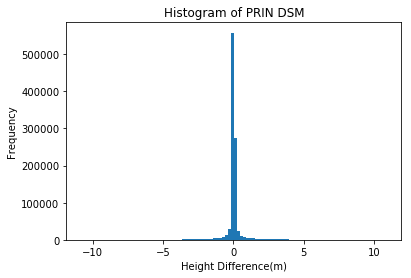

In [38]:
plt.figure(1)
plt.hist(diff_dsm_array.flatten(),100)
plt.title('Histogram of PRIN DSM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

The histogram has long tails, obscuring the distribution near the center. To constrain the x-limits of the histogram we will use the mean and standard deviation just calculated. Since the data appears to be normally distributed, we can constrain the histogram to 95% of the data by including 2 standard deviations above and below the mean.   

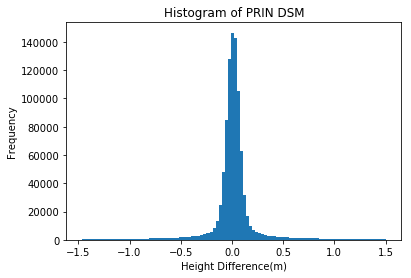

In [39]:
plt.figure(1)
plt.hist(diff_dsm_array.flatten(),100,range=[diff_dsm_array_mean-2*diff_dsm_array_std, diff_dsm_array_mean+2*diff_dsm_array_std])
plt.title('Histogram of PRIN DSM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')


The histogram shows a wide variation in DSM differences, with those at the 95% limit at around +/- 1.5 m. Let's take a look at the spatial distribution of the errors by plotting a map of the difference between the two DSMs. Here we'll also use the extra variable in the plot function to constrain the limits of the colorbar to 95% of the observations. 

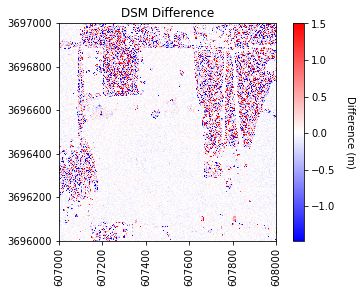

In [40]:
plt.figure(3)
plot_band_array(diff_dsm_array,image_extent,'DSM Difference','Difference (m)','bwr',[diff_dsm_array_mean-2*diff_dsm_array_std, diff_dsm_array_mean+2*diff_dsm_array_std])


It seems that there is a spatial pattern in the distribution of errors. Now let's take a look at the histogram and map for the difference in DTMs

Mean difference in DTMs:  0.014  (m)
Standard deviations of difference in DTMs:  0.102  (m)


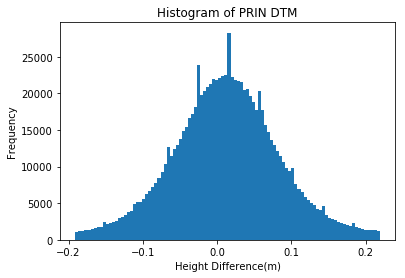

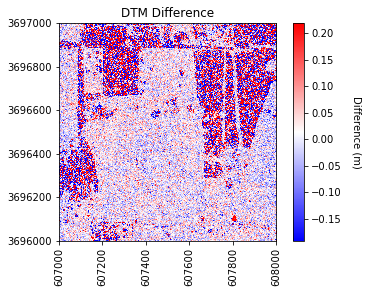

In [41]:
diff_dtm_array_mean = np.nanmean(diff_dtm_array)
diff_dtm_array_std = np.nanstd(diff_dtm_array)
print('Mean difference in DTMs: ',round(diff_dtm_array_mean,3),' (m)')
print('Standard deviations of difference in DTMs: ',round(diff_dtm_array_std,3),' (m)')          

plt.figure(4)
plt.hist(diff_dtm_array.flatten()[~np.isnan(diff_dtm_array.flatten())],100,range=[diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])
plt.title('Histogram of PRIN DTM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

plt.figure(5)
plot_band_array(diff_dtm_array,image_extent,'DTM Difference','Difference (m)','bwr',[diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])

The overall magnitude of differences are smaller, but the same spatial pattern of the error is evident. Now, we'll plot the Canopy Height Model (CHM) of the same area. In the CHM, the tree heights above ground are represented, with all ground pixels having zero elevation. This time we'll use a colorbar which shows the ground as light gray and the highest vegetation as dark green. We can set the lower limit of the color bar to zero and the upper limit to the mean canopy height to get a good color variation. 

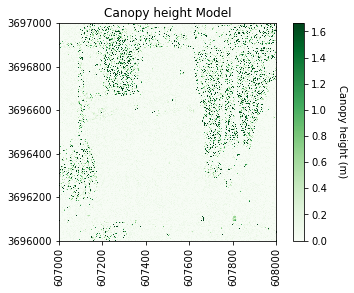

In [42]:
chm_array_mean = np.nanmean(chm_array)
chm_array_std = np.nanstd(chm_array)
plt.figure(6)
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, chm_array_mean])
plt.savefig('PRIN_CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

From the CHM, it appears the spatial distribution of error patterns follow the location of vegetation. Now let's isolate the only the pixels in the difference DSM that correspond to vegetation location, calcualte the mean and standard deviation and plot the associated histogram. Before displaying the histogram, we'll remove the no data values from the difference DSM and the non-zero pixels from the CHM. To keep the number of elements the same in each vector to allow element-wise logical operations in Python, we have to remove the difference DSM no data elements from the CHM array as well. 

Mean difference in DSMs on veg points:  0.064  (m)
Standard deviations of difference in DSMs on veg points:  1.381  (m)


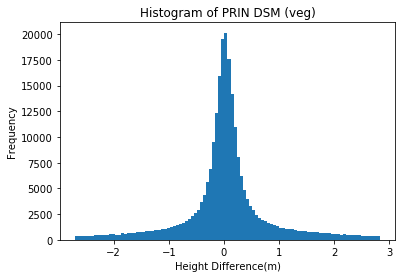

In [43]:
diff_dsm_array_veg_mean = np.nanmean(diff_dsm_array[chm_array!=0.0])
diff_dsm_array_veg_std = np.nanstd(diff_dsm_array[chm_array!=0.0])
plt.figure(7)
print('Mean difference in DSMs on veg points: ',round(diff_dsm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DSMs on veg points: ',round(diff_dsm_array_veg_std,3),' (m)')

plt.figure(8)
diff_dsm_array_nodata_removed = diff_dsm_array[~np.isnan(diff_dsm_array)]
chm_dsm_nodata_removed = chm_array[~np.isnan(diff_dsm_array)]
plt.hist(diff_dsm_array_nodata_removed[chm_dsm_nodata_removed!=0.0],100,range=[diff_dsm_array_veg_mean-2*diff_dsm_array_veg_std, diff_dsm_array_veg_mean+2*diff_dsm_array_veg_std])
plt.title('Histogram of PRIN DSM (veg)')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')


The results show a similar mean difference of near zero, but an extremely high variation of 1.381 m! Since the DSM represents the top of the tree canopy, this provides the level of uncertainty we can expect in the canopy height in forests characteristic of the PRIN site using NEON LiDAR data. Next we'll calculate the statistics and plot the histogram of the DTM vegetated areas

Mean difference in DTMs on veg points:  0.023  (m)
Standard deviations of difference in DTMs on veg points:  0.163  (m)


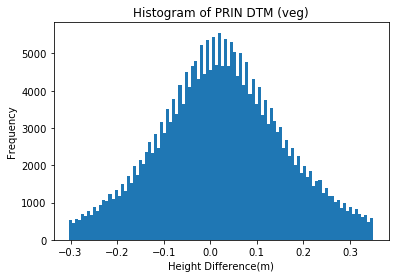

In [44]:
diff_dtm_array_veg_mean = np.nanmean(diff_dtm_array[chm_array!=0.0])
diff_dtm_array_veg_std = np.nanstd(diff_dtm_array[chm_array!=0.0])
plt.figure(9)
print('Mean difference in DTMs on veg points: ',round(diff_dtm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DTMs on veg points: ',round(diff_dtm_array_veg_std,3),' (m)')

plt.figure(10)
diff_dtm_array_nodata_removed = diff_dtm_array[~np.isnan(diff_dtm_array)] 
chm_dtm_nodata_removed = chm_array[~np.isnan(diff_dtm_array)]
plt.hist((diff_dtm_array_nodata_removed[chm_dtm_nodata_removed!=0.0]),100,range=[diff_dtm_array_veg_mean-2*diff_dtm_array_veg_std, diff_dtm_array_veg_mean+2*diff_dtm_array_veg_std])
plt.title('Histogram of PRIN DTM (veg)')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

Here we can see that the mean difference is almost zero at 0.003 m, and the variation in less than the DSM at 0.257 m. Although the variation is reduced, it is still larger than expected for LiDAR. This is because under vegetation there may not be much laser energy reaching the ground, and those points that do may return with lower signal. The sparsity of points leads to surface interpolation over larger areas which can miss variations in the topography. Since the distribution of LIDAR and their location varied for each day, this resulted in different terrain representations and a uncertianty in the ground surface. This shows that the accuracy of LiDAR DTMs is reduced when under vegetation. Finally, let's look at the DTM difference on only the ground points (where CHM = 0).

Mean difference in DTMs on ground points:  0.011  (m)
Standard deviations of difference in DTMs on ground points:  0.068  (m)


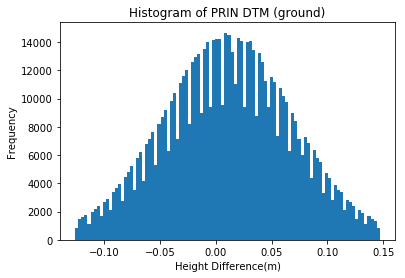

In [45]:
diff_dtm_array_ground_mean = np.nanmean(diff_dtm_array[chm_array==0.0])
diff_dtm_array_ground_std = np.nanstd(diff_dtm_array[chm_array==0.0])
print('Mean difference in DTMs on ground points: ',round(diff_dtm_array_ground_mean,3),' (m)')
print('Standard deviations of difference in DTMs on ground points: ',round(diff_dtm_array_ground_std,3),' (m)')

plt.figure(11)
plt.hist((diff_dtm_array_nodata_removed[chm_dtm_nodata_removed==0.0]),100,range=[diff_dtm_array_ground_mean-2*diff_dtm_array_ground_std, diff_dtm_array_ground_mean+2*diff_dtm_array_ground_std])
plt.title('Histogram of PRIN DTM (ground)')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')


In the open ground scenario we are able to produce the error chatracteristics we expect with a mean difference of only 0.011 m and a variation of 0.068 m. This shows that the uncertainty we expect in the NEON LiDAR system (~0.15 m) is only valid in bare open, har surface scenarios. We cannot expect the accuracy of the LiDAR to reach this level when vegetation is present. Quantifying the top of the canopy is particularly difficult and can lead to uncertainty in excess of 1 m for any given pixel.  